## Waste Sorter (Working Title)


In [43]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [44]:
from fastai.vision import *
from fastai.vision.transform import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os, shutil
import zipfile as zf
import shutil
import re
import seaborn as sns
import glob

## Extraction

In [126]:
dataset_name = "trashnet-extended"
waste_types = ['cardboard','glass','metal','paper','plastic','trash',"food"]
batch_size = 10
trained_model_path = "data"    #Leave as None if you want to retrain your model/do not have a trained model

In [45]:
# os.path.exists('data') and shutil.rmtree('data')
os.path.exists(dataset_name) and shutil.rmtree(dataset_name)
    
# files = zf.ZipFile(dataset_name+".zip",'r')
# files.extractall()
# files.close()

Split into train, valid and test

#### Run this to create the data folder:

In [127]:
for subset in ['train','valid']:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)

if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))    

for waste_type in waste_types:
    fnames = {}
    filecount = 0
    for file in glob.glob(dataset_name + "/" + waste_type + "/*.jpg"):
        fnames[filecount + 1] = os.path.basename(file)
        filecount += 1
    random.seed(1)
    full_set = list(range(1,filecount+1))
    train = random.sample(full_set,int(.5*filecount)) 
    remaining = list(set(full_set)-set(train))
    valid = random.sample(remaining,int(.5*len(remaining)))
    test = list(set(remaining)-set(valid))
    
    source_folder = os.path.join(dataset_name, waste_type)
    train = [os.path.join(source_folder,fnames[i]) for i in train]
    valid = [os.path.join(source_folder,fnames[i]) for i in valid]
    test = [os.path.join(source_folder,fnames[i]) for i in test]
    
    move_files(train,"data/train/"+waste_type)
    move_files(valid,"data/valid/"+waste_type)
    move_files(test,"data/test")

In [ ]:
#### If you already have a data folder, run this:

In [131]:
path = Path(os.getcwd())/"data"
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",size=(512,384), resize_method=ResizeMethod.SQUISH,ds_tfms=tfms, bs=batch_size)
print(data.classes)
print(data)

['cardboard', 'food', 'glass', 'metal', 'paper', 'plastic', 'trash']
ImageDataBunch;

Train: LabelList (1300 items)
x: ImageList
Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: /home/gr00t/stuff/workspaces/HB20/data;

Valid: LabelList (650 items)
x: ImageList
Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: /home/gr00t/stuff/workspaces/HB20/data;

Test: LabelList (654 items)
x: ImageList
Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 384)
y: EmptyLabelList
,,,,
Path: /home/gr00t/stuff/workspaces/HB20/data


## Model training

#### If you have a trained model, run this and skip to classification:

In [ ]:
if trained_model_path is not None:
    learn = load_learner(trained_model_path)

#### Otherwise, train the model:

In [54]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)
learn.model

### Finding a learning rate - Jeremy Jordan's [post](https://www.jeremyjordan.me/nn-learning-rate/)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


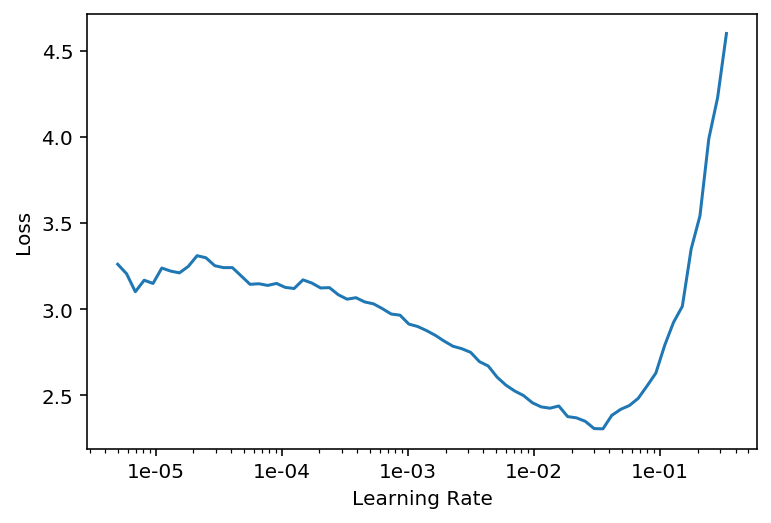

In [56]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

The learning rate finder suggests a learning rate of 5.13e-03. With this, we can train the model.

### Training

In [58]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.650084,0.762636,0.249231,07:10
1,1.078132,0.616389,0.200000,07:05
2,1.010318,0.588762,0.201538,07:06
3,1.027626,0.778410,0.230769,07:18
4,1.183291,0.871130,0.296923,07:22
5,1.015795,0.840559,0.256923,07:19
6,1.050635,0.803390,0.250769,07:22
7,0.961887,0.571489,0.178462,07:20
8,0.876506,0.599963,0.190769,07:17
9,0.804363,0.579420,0.189231,22:02


In [60]:
learn.export()
learn.path

PosixPath('/home/gr00t/stuff/workspaces/HB20/data')

### VIsualizing most incorrect images

In [100]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

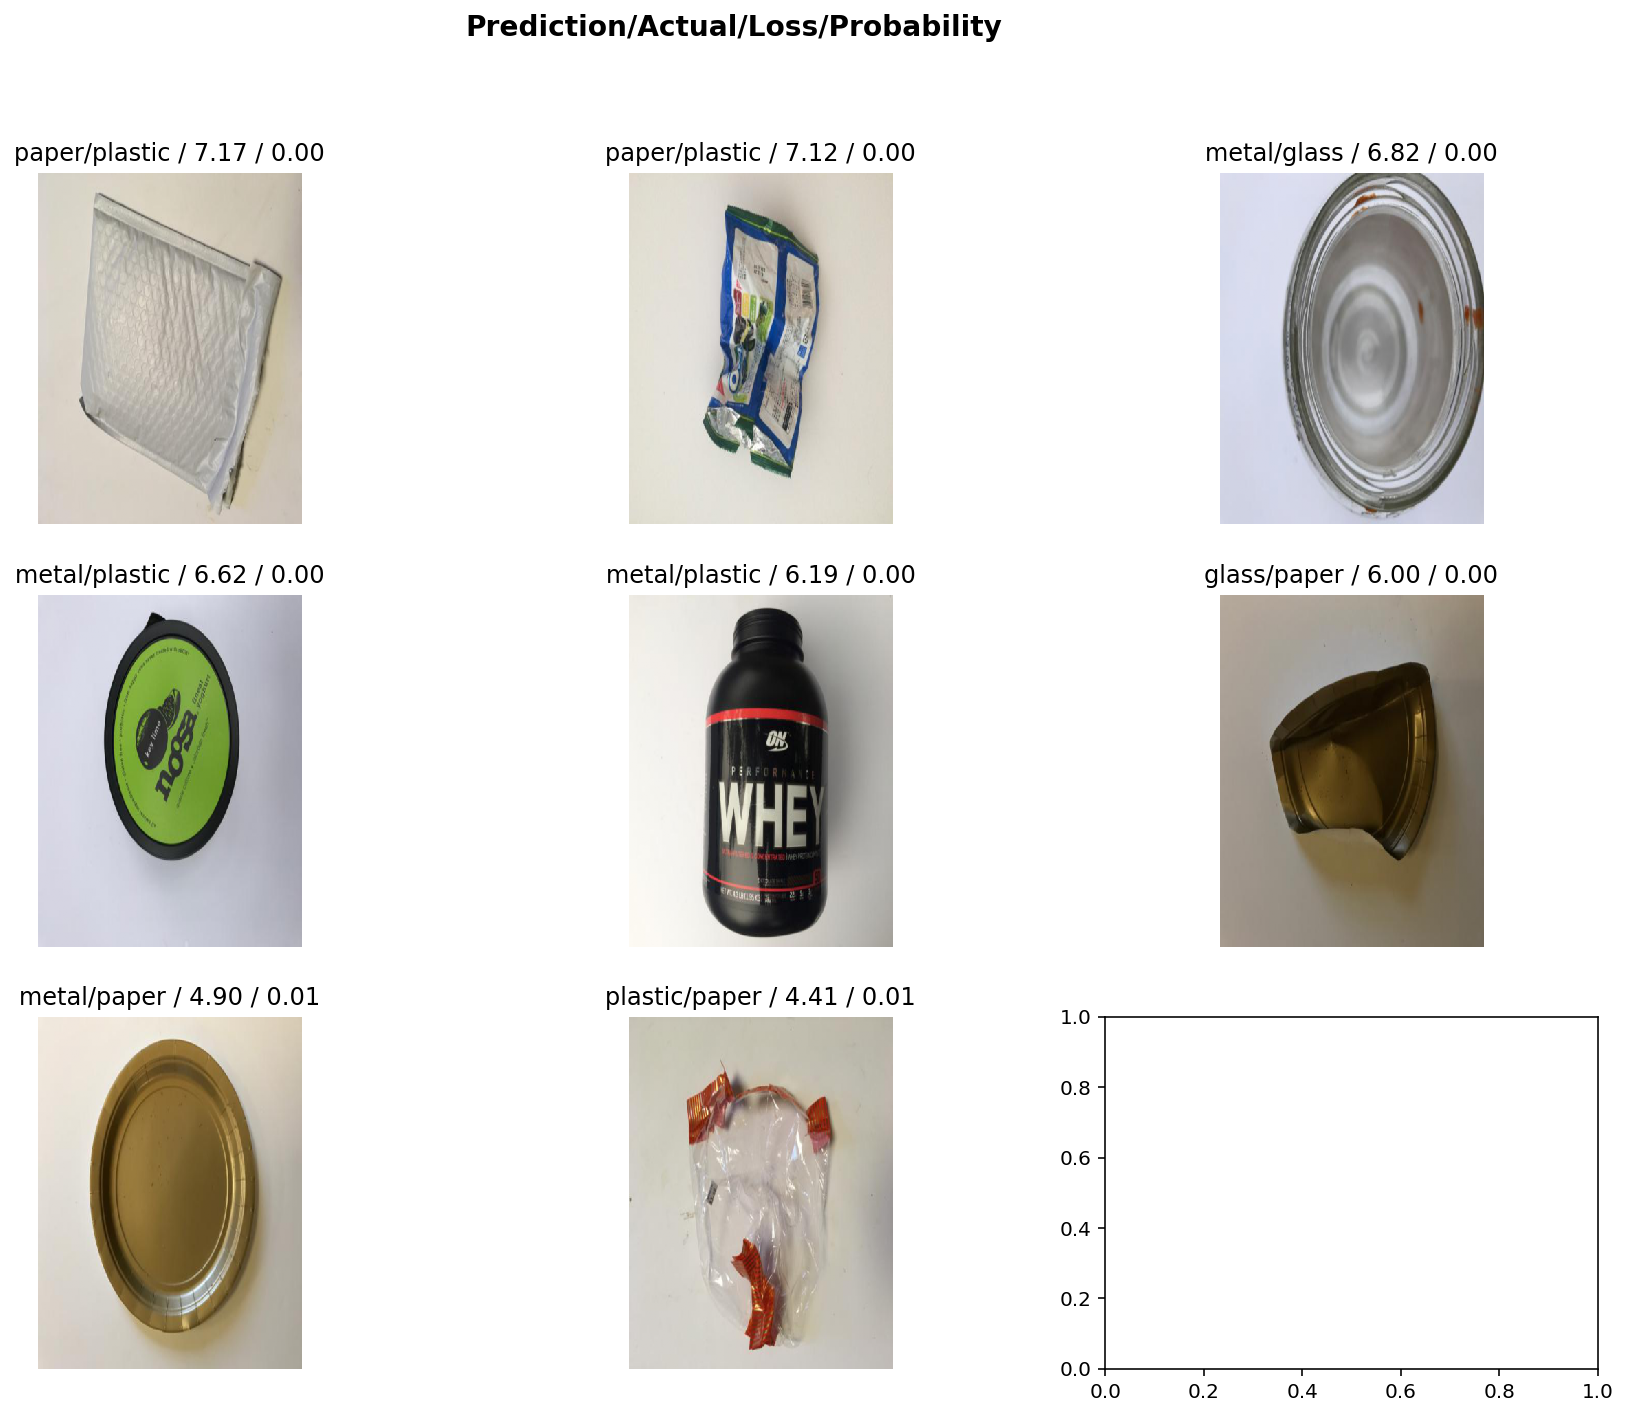

In [63]:
interp.plot_top_losses(8, figsize=(15,11))

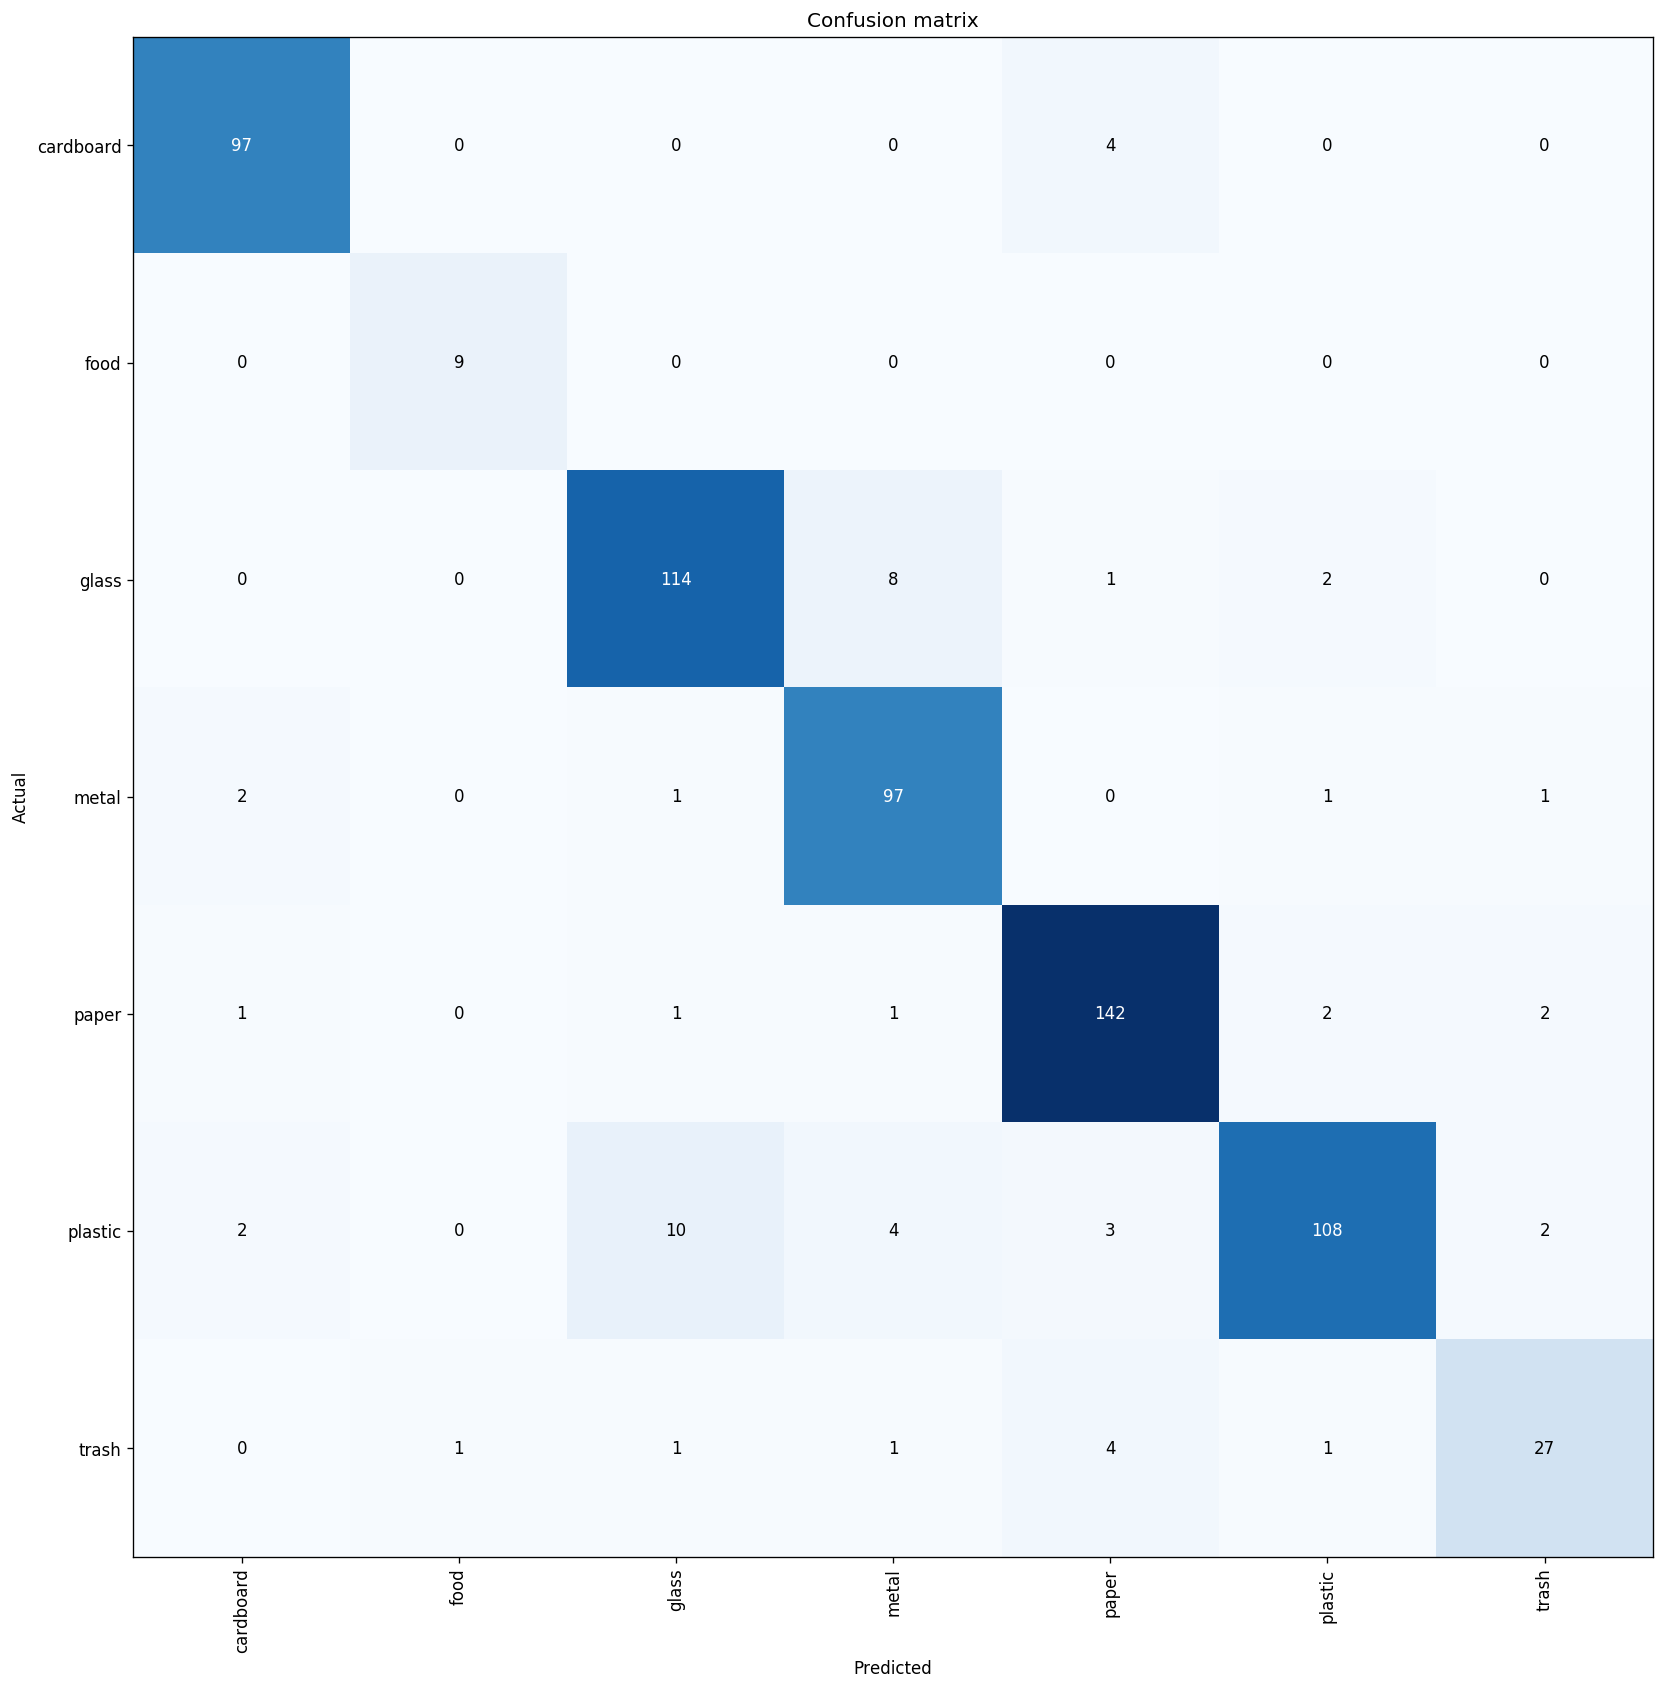

In [64]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(14,14), dpi=60)

In [65]:
interp.most_confused(min_val=2)

[('plastic', 'glass', 10),
 ('glass', 'metal', 8),
 ('cardboard', 'paper', 4),
 ('plastic', 'metal', 4),
 ('trash', 'paper', 4),
 ('plastic', 'paper', 3),
 ('glass', 'plastic', 2),
 ('metal', 'cardboard', 2),
 ('paper', 'plastic', 2),
 ('paper', 'trash', 2),
 ('plastic', 'cardboard', 2),
 ('plastic', 'trash', 2)]

## Yayyyy prediction time

In [68]:
preds = learn.get_preds(ds_type=DatasetType.Test)
print(preds[0].shape)
preds[0]

torch.Size([654, 7])


tensor([[9.8562e-01, 2.2515e-06, 4.5867e-03,  ..., 7.7815e-03, 6.0551e-04,
         7.5002e-04],
        [9.9417e-01, 5.5676e-06, 5.4015e-04,  ..., 2.7041e-05, 5.0051e-03,
         2.3193e-04],
        [9.2235e-01, 2.0862e-02, 1.5983e-04,  ..., 1.9033e-02, 3.1178e-02,
         6.2225e-03],
        ...,
        [1.5981e-05, 1.6874e-05, 6.3650e-05,  ..., 6.5654e-01, 5.7149e-05,
         3.4330e-01],
        [9.3644e-01, 1.6789e-05, 4.3713e-04,  ..., 2.5396e-02, 1.0664e-04,
         4.0962e-03],
        [3.9766e-04, 2.2292e-04, 1.4234e-06,  ..., 9.0665e-03, 8.6413e-05,
         9.9017e-01]])

In [69]:
data.classes

['cardboard', 'food', 'glass', 'metal', 'paper', 'plastic', 'trash']

Convert probabilities to class labels

In [71]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])
yhat

Check accuracy since we know the actual labels of 'test'

In [96]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("[a-z]+\/([a-z]+)[0-9]+\.jpg$")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)
    
cm = confusion_matrix(y,yhat)

df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [92]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]
accuracy = correct/sum(sum(cm))
accuracy

In [50]:
## delete everything when you're done to save space
# shutil.rmtree("data")
# shutil.rmtree('dataset-resized')

# Check for single image

In [99]:
for i in ["chips","bottle","bowl","fork","cup"]:
    pred = learn.predict(open_image(f"realtest/"+i+".jpeg"))
    print(i+": "+str(pred))

chips: (Category paper, tensor(4), tensor([0.0147, 0.0049, 0.0140, 0.0488, 0.8298, 0.0035, 0.0844]))
bottle: (Category plastic, tensor(5), tensor([4.8729e-02, 2.0950e-04, 9.3875e-02, 1.0398e-02, 4.0840e-02, 8.0534e-01,
        6.1344e-04]))
bowl: (Category glass, tensor(2), tensor([4.7838e-06, 2.3041e-02, 8.2467e-01, 7.1471e-02, 4.4926e-03, 7.1481e-02,
        4.8418e-03]))
fork: (Category plastic, tensor(5), tensor([4.1540e-05, 4.7827e-05, 1.3171e-01, 1.1177e-01, 2.1894e-02, 7.1780e-01,
        1.6743e-02]))
cup: (Category glass, tensor(2), tensor([1.7682e-04, 1.0228e-04, 9.6875e-01, 4.9812e-03, 2.7844e-03, 2.3193e-02,
        9.5826e-06]))
